# Torrens University
**ISY503 - Intelligent Systems**

**Assessment 3, Vision Project - Self driving car**

**Lecturer: Aaron Bere**

* Group 1 - Members:
    * Daniela Alejandra Renz, A0005295
    * Diana Paola Baquero Almanza, A00062732
    * Kevalkumar hiteshkumar patel, A00080494
    * Camilo Andres Bogota Ospina, A00053712
    
December/2022


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import tensorflow as tf
import ntpath
import random

# Implementation for Track 2 (Right side)
**Training the model**

In [2]:
datadir = 'Sim\CABO-2Track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

C:\Users\camil\AppData\Local\Temp\ipykernel_14020\1579136139.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


center  \
0  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\center_2022_12_01_14_34_02_798.jpg   
1  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\center_2022_12_01_14_34_02_869.jpg   
2  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\center_2022_12_01_14_34_02_936.jpg   
3  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\center_2022_12_01_14_34_03_007.jpg   
4  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\center_2022_12_01_14_34_03_075.jpg   

                                                                             left  \
0  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\left_2022_12_01_14_34_02_798.jpg   
1  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\left_2022_12_01_14_34_02_869.jpg   
2  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\left_2022_12_01_14_34_02_936.jpg   
3  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\left_2022_12_01_14_34_03_007.jpg   
4  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\left_2022_12_01_14_34_03_075.jpg   

                                                                             right  \
0  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\right_2022_12_01_14_34_02_798.jpg   
1  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\right_2022_12_01_14_34_02_869.jpg   
2  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\right_2022_12_01_14_34_02_936.jpg   
3  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\right_2022_12_01_14_34_03_007.jpg   
4  C:\Users\camil\Car\ISY503\Sim\CABO-2Track\IMG\right_2022_12_01_14_34_03_075.jpg   

   steering  throttle  reverse     speed  
0  0.00      0.089789  0.0      25.42241  
1  0.00      0.336604  0.0      25.22474  
2  0.00      0.512752  0.0      25.36900  
3  0.00      0.750473  0.0      25.44943  
4  0.15      0.927789  0.0      25.31459

In [3]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2022_12_01_14_34_02_798.jpg  left_2022_12_01_14_34_02_798.jpg   
1  center_2022_12_01_14_34_02_869.jpg  left_2022_12_01_14_34_02_869.jpg   
2  center_2022_12_01_14_34_02_936.jpg  left_2022_12_01_14_34_02_936.jpg   
3  center_2022_12_01_14_34_03_007.jpg  left_2022_12_01_14_34_03_007.jpg   
4  center_2022_12_01_14_34_03_075.jpg  left_2022_12_01_14_34_03_075.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2022_12_01_14_34_02_798.jpg  0.00      0.089789  0.0      25.42241  
1  right_2022_12_01_14_34_02_869.jpg  0.00      0.336604  0.0      25.22474  
2  right_2022_12_01_14_34_02_936.jpg  0.00      0.512752  0.0      25.36900  
3  right_2022_12_01_14_34_03_007.jpg  0.00      0.750473  0.0      25.44943  
4  right_2022_12_01_14_34_03_075.jpg  0.15      0.927789  0.0      25.31459

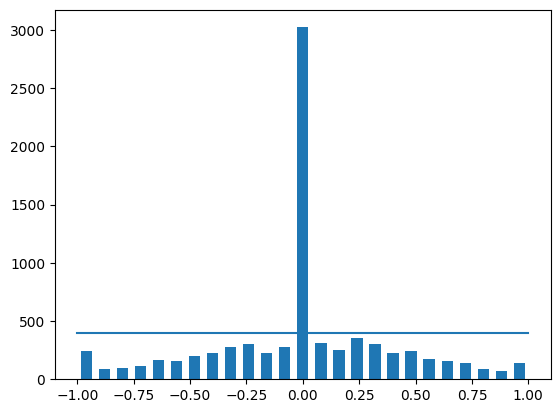

In [4]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), \
(samples_per_bin, samples_per_bin))

total data: 7876
removed: 2622
remaining: 5254


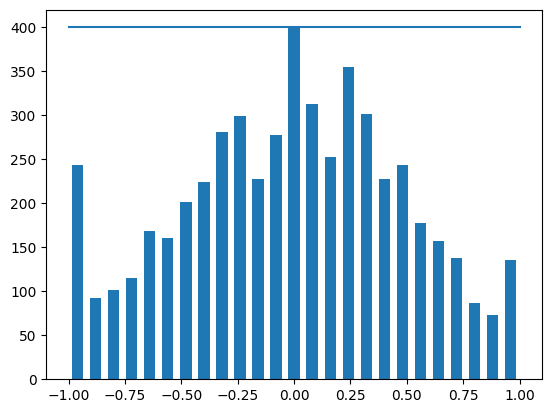

In [5]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), \
(samples_per_bin, samples_per_bin))

In [6]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2022_12_01_14_34_03_007.jpg
left        left_2022_12_01_14_34_03_007.jpg  
right       right_2022_12_01_14_34_03_007.jpg 
steering    0.0                               
throttle    0.750473                          
reverse     0.0                               
speed       25.44943                          
Name: 3, dtype: object


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, \
test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 12609
Valid Samples: 3153


Text(0.5, 1.0, 'Validation set')

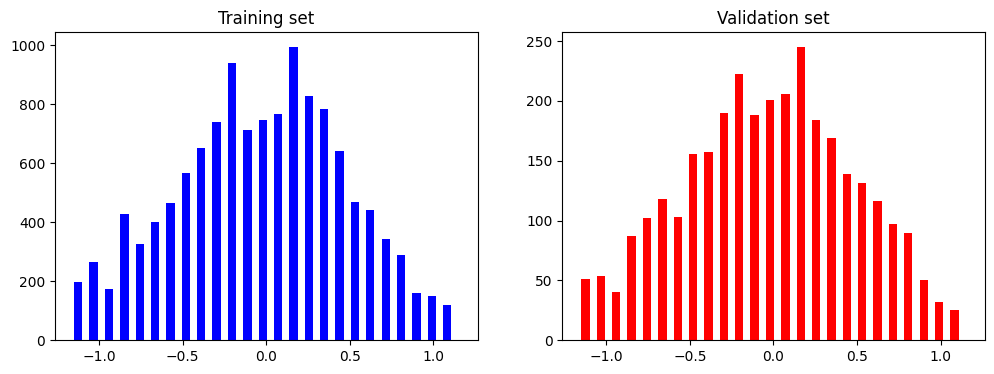

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

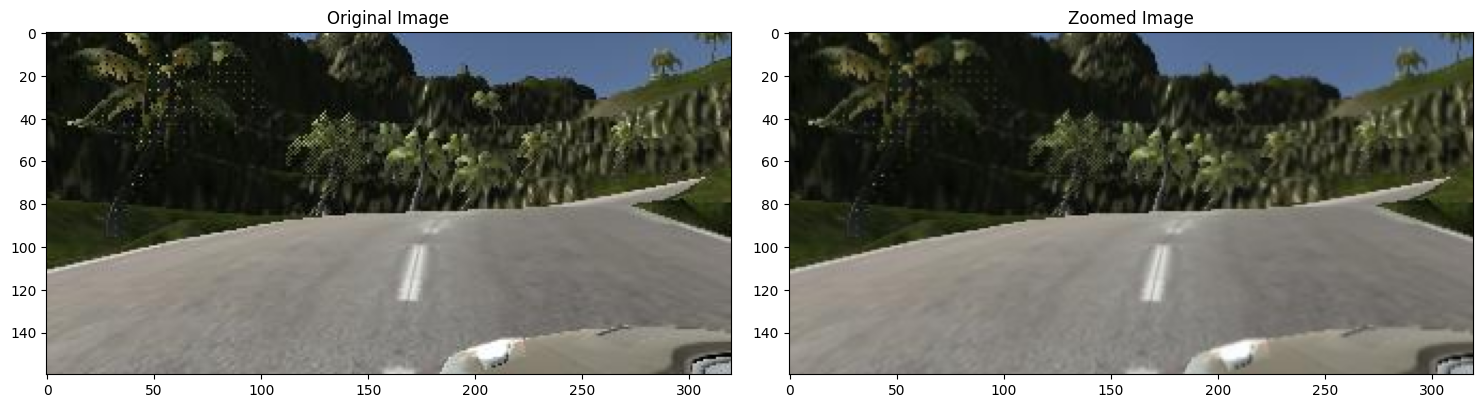

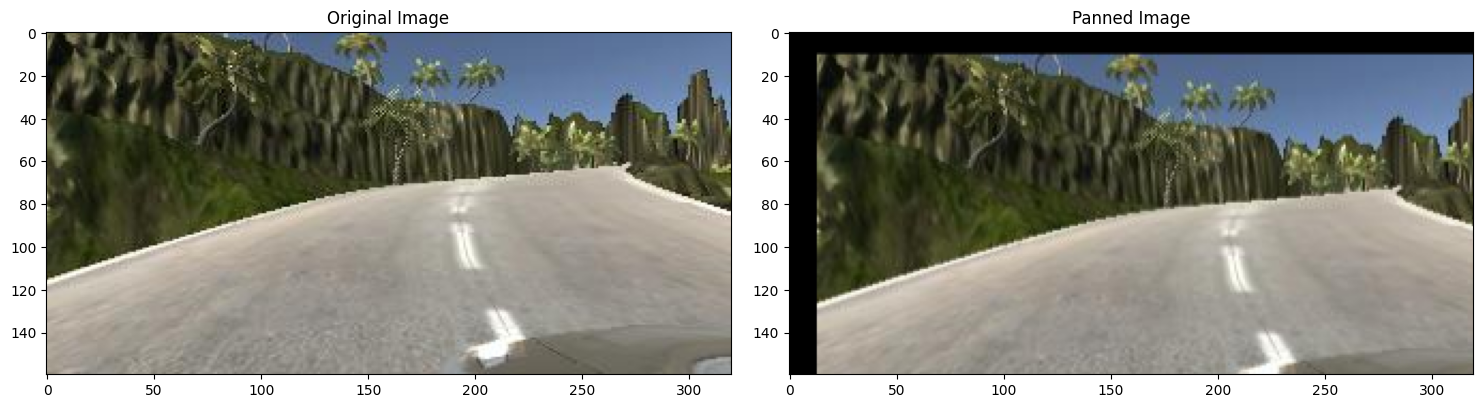

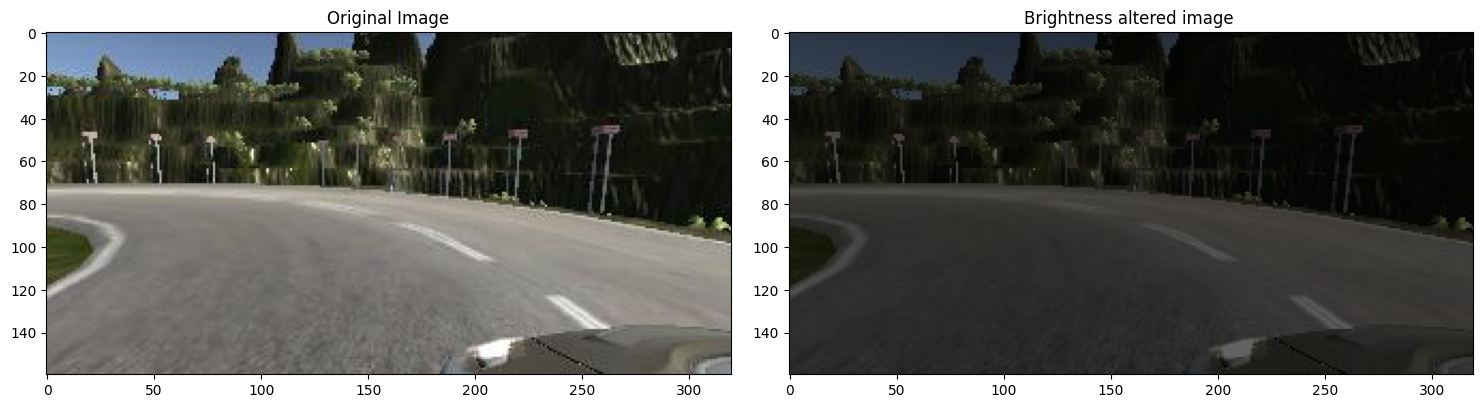

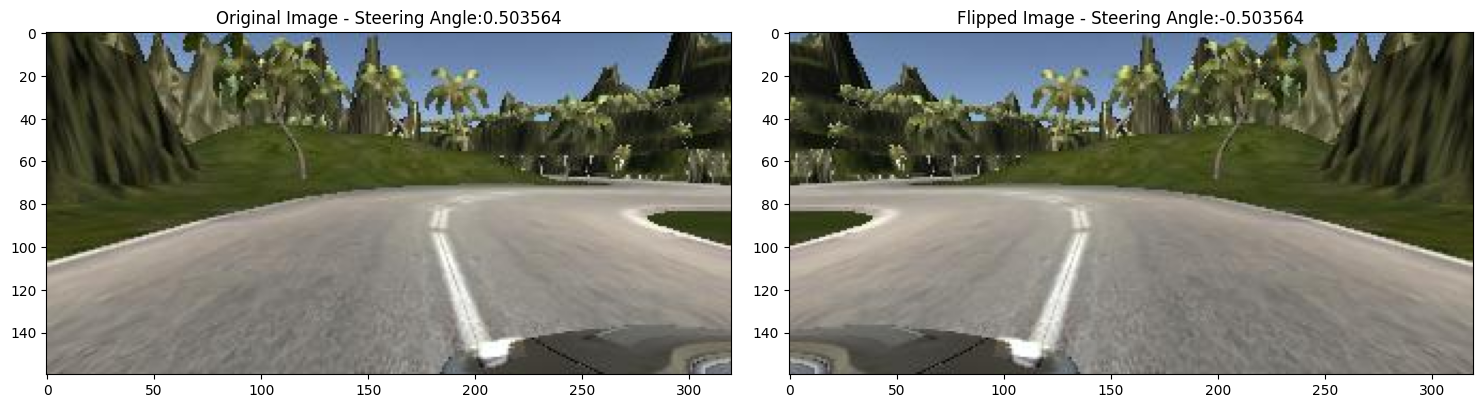

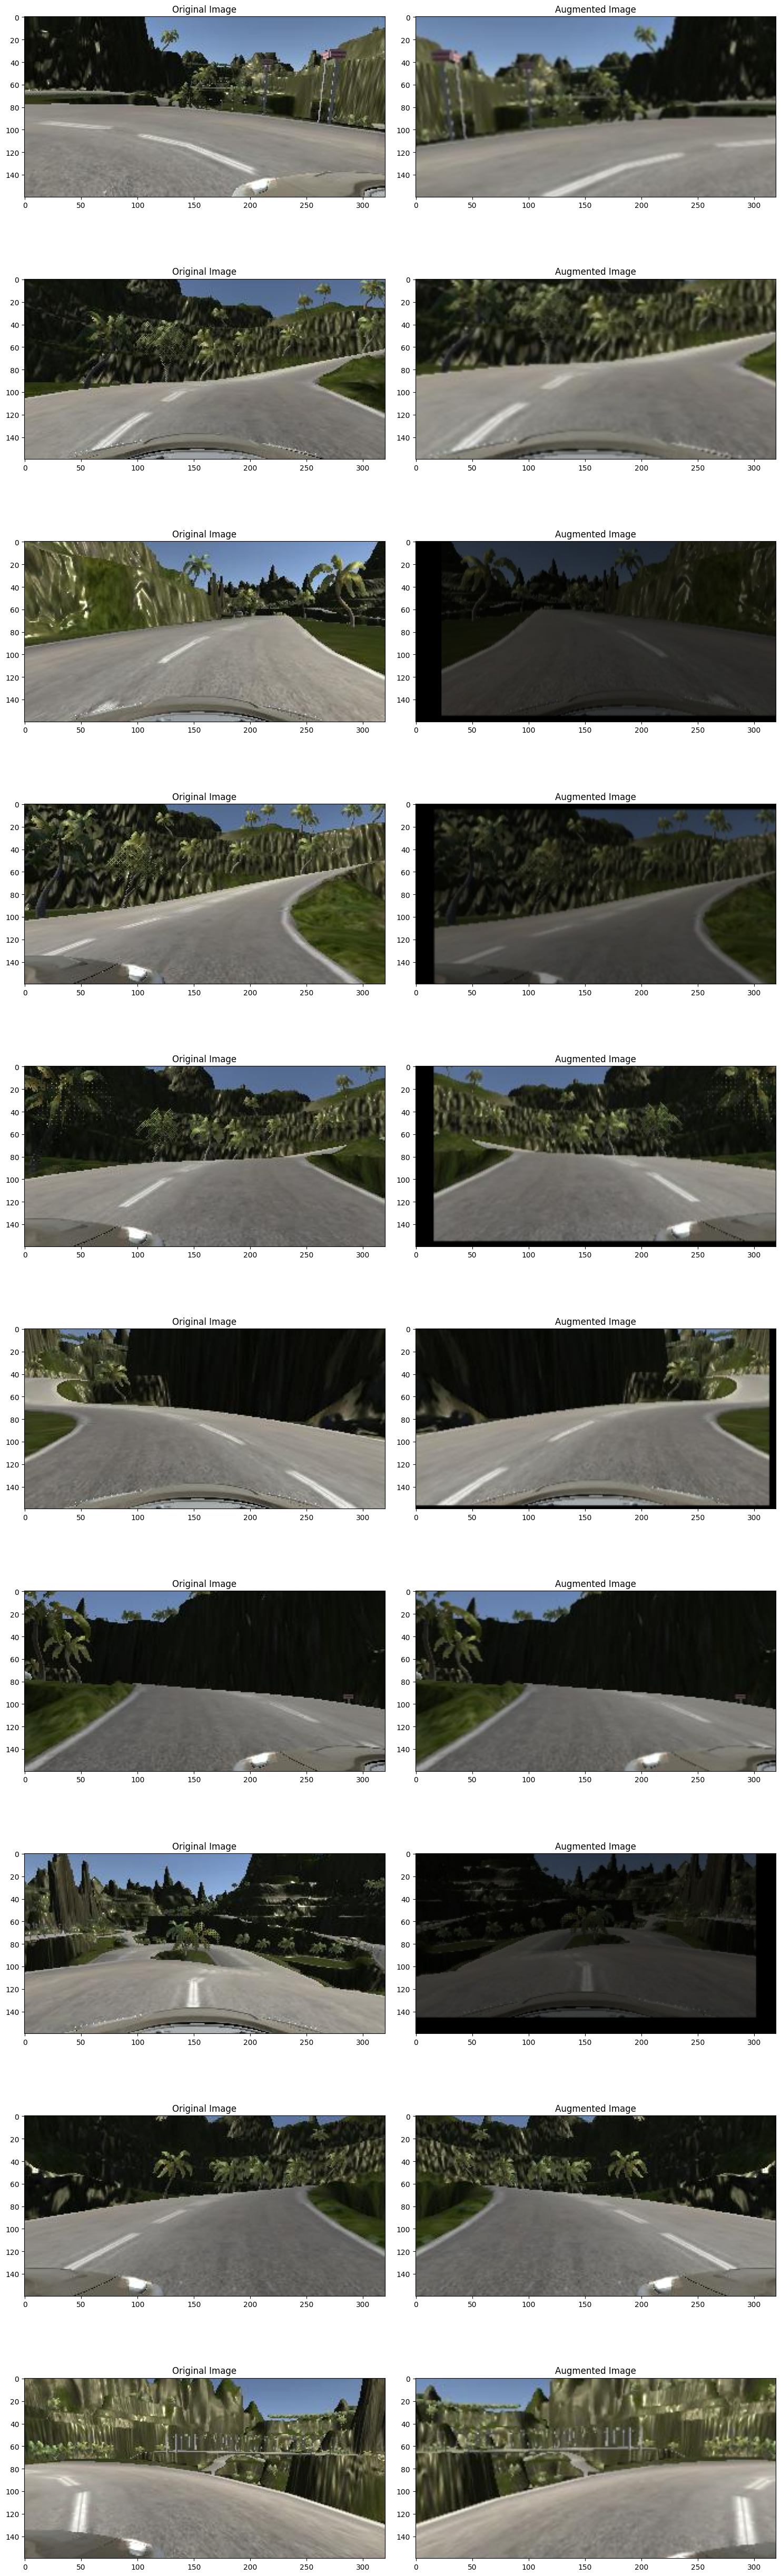

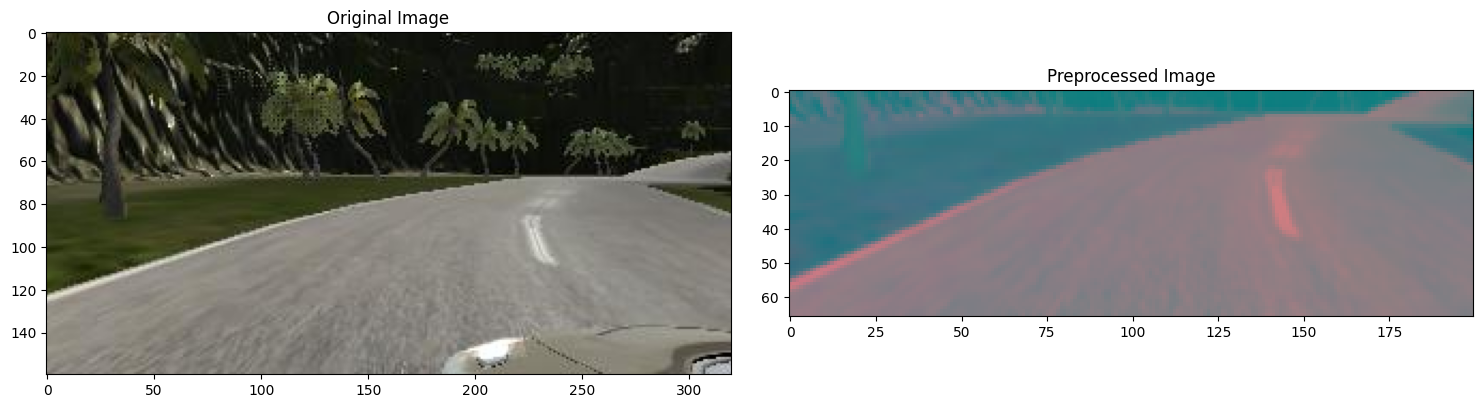

In [9]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")
 
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [10]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Flatten())
  model.add(Convolution2D(64, (3, 3), activation='elu'))

In [11]:
# Original
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  
  model.add(Convolution2D(64, (3, 3), activation='elu'))
#   model.add(Dropout(0.5))  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

C:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\camil\AppData\Local\Temp\ipykernel_14020\3525039706.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


None
Epoch 1/10
300/300 [==============================] - 282s 939ms/step - loss: 0.1896 - val_loss: 0.1092
Epoch 2/10
300/300 [==============================] - 320s 1s/step - loss: 0.1148 - val_loss: 0.0953
Epoch 3/10
300/300 [==============================] - 291s 971ms/step - loss: 0.1030 - val_loss: 0.0945
Epoch 4/10
300/300 [==============================] - 295s 987ms/step - loss: 0.0977 - val_loss: 0.0791
Epoch 5/10
300/300 [==============================] - 247s 824ms/step - loss: 0.0912 - val_loss: 0.0820
Epoch 6/10
300/300 [==============================] - 331s 1s/step - loss: 0.0869 - val_loss: 0.0730
Epoch 7/10
300/300 [==============================] - 395s 1s/step - loss: 0.0854 - val_loss: 0.0712
Epoch 8/10
300/300 [==============================] - 375s 1s/step - loss: 0.0825 - val_loss: 0.0714
Epoch 9/10
300/300 [==============================] - 368s 1s/step - loss: 0.0832 - val_loss: 0.0713
Epoch 10/10
300/300 [==============================] - 367s 1s/step - loss

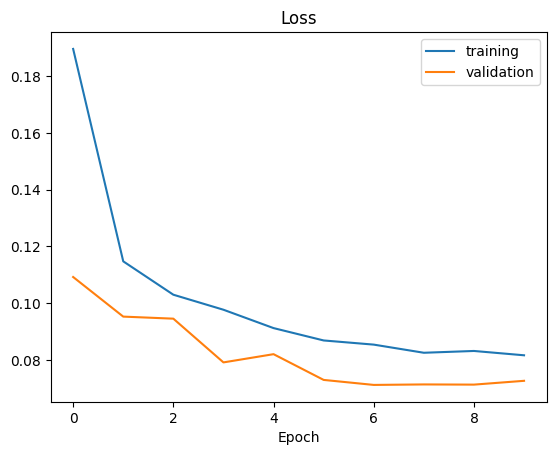

In [12]:
#def nvidia_model():
model = nvidia_model()

print(model.summary())
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), 
                                steps_per_epoch=300, 
                                epochs=10,
                                validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                validation_steps=200,
                                verbose=1,
                                shuffle = 1)
  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')




In [ ]:
model.save('modelT2v4.h5')